In [ ]:
%reset -f
%matplotlib inline

In [679]:
%load_ext autoreload
%autoreload 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import torch
import torch.nn as nn
from skimage.transform import resize
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib

In [71]:
%autoreload 
from neural_network.trainer import load_trainer
trainer, dataset, model = load_trainer('resnet50')

Dataset sizes - Training: 421 Validation: 47 Test: 0
Loading architecture from logs/tb_logs/lightning/resnet50/version_0/checkpoints/checkpoint-v1.ckpt (checkpoint)..


GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: None, using: 0 TPU cores
INFO:lightning:TPU available: None, using: 0 TPU cores


Architecture [ResNet] was created
***Defined hyperparameters:***
"architecture_name":   resnet50
"checkpoint_path":     None
"class_weights":       None
"hp_metrics":          ['loss/val', 'loss/train', 'accuracy/val', 'auc/val', 'specificity/val', 'sensitivity/val']
"is_train":            True
"loss_weight_balance": True
"lr":                  0.0002
"lr_decay_iters":      10
"lr_policy":           step
"max_epochs":          200
"model_name":          lightning
"opt_amsgrad":         False
"opt_weight_decay":    1e-05
***Defined hyperparameters:***
"architecture_name":   resnet50
"checkpoint_path":     logs/tb_logs/lightning/resnet50/version_0/checkpoints/checkpoint-v1.ckpt
"class_weights":       None
"hp_metrics":          ['loss/val', 'loss/train', 'accuracy/val', 'auc/val', 'specificity/val', 'sensitivity/val']
"is_train":            True
"loss_weight_balance": True
"lr":                  0.0002
"lr_decay_iters":      10
"lr_policy":           step
"max_epochs":          200
"mode

In [ ]:
%autoreload 
trainer.fit(
    model, 
    datamodule=dataset
)

# Example model to plot CAMS

In [688]:
from neural_network.utils.cam import get_cam
from neural_network.utils import plot
from neural_network.utils import move_to_device, to_cpu_numpy
from utils import parula_map
def cam_example(model, extractor_name:str='SmoothGradCAMpp',img_size:tuple=(79,95,79),cmap:str=parula_map, alpha:float=0.3, observed_class:str=None, load_image:str='CN',max_num_slices=None):
    #label = 0

    image = {
        'CN':nib.load('data/SPM_categorised/AIH/CN/CN_ADNI_998.nii').get_fdata,
        'MCI':nib.load('data/SPM_categorised/AIH/MCI/MCI_ADNI_1586.nii').get_fdata,
        'AD':nib.load('data/SPM_categorised/AIH/AD/AD_ADNI_2975.nii').get_fdata
    }[load_image]()
    label_to_class = {
        0:'CN',
        1:'MCI',
        2:'AD'
    }
    class_to_label = {v: k for k, v in label_to_class.items()}
    
    image = torch.from_numpy(resize(image, img_size)).float()
    
    assert tuple(image.shape) == img_size
    
    model, image = move_to_device(model, image, 'cuda')

    mask, predicted_label = get_cam(model, image, extractor_name=extractor_name, observed_label=class_to_label.get(observed_class, None))
    

    assert observed_class != None and observed_class == label_to_class[predicted_label] or observed_class == None, f"Expected predicted_label class to be {observed_class}. Got: {label_to_class[predicted_label]}"
    
    predicted_override=True if observed_class != None else False
    
    fig = plot.cam_grid(to_cpu_numpy(image), mask, model_name=type(model.model.model).__name__,predicted_label=label_to_class[predicted_label], class_label=load_image,extractor=extractor_name,cmap=cmap, alpha=alpha, predicted_override=predicted_override,max_num_slices=max_num_slices)

    return (fig, to_cpu_numpy(image),mask, predicted_label)
        

In [89]:
isinstance(None,type(None))

True

In [ ]:
from torch.utils.tensorboard import SummaryWriter
tb_writer = SummaryWriter(log_dir=f'logs/visualisation/{type(model.model.model).__name__}/version_{round(time.time())}', filename_suffix='.CAM')

In [690]:
# Iterate all cams
import time

#tb_writer = trainer.logger.experiment
plot_cams = {
    'CAM':{},
    'GradCAM':{},
    'GradCAMpp':{},
    'SmoothGradCAMpp':{},
    'Saliency':{'cmap':'hot', 'alpha':1},
    #'ScoreCAM':{},
    #'SSCAM':{},
    #'ISCAM':{},
}
images = ['CN','MCI','AD']
observed_classes = ['CN','MCI','AD',None]
errors = []

for extractor_name, params in plot_cams.items():
    for image in images:
        tmp_image = None
        for observed_class in observed_classes:
            try:
                fig,tmp_image,_,_ = cam_example(model,extractor_name=extractor_name, **params,load_image=image,observed_class=observed_class,max_num_slices=16)
                tb_writer.add_figure(f"{extractor_name}/{image}/{observed_class}",fig)
                
            except RuntimeError as e:
                errors.append((f'Model: {extractor_name} {e}'))
        if not isinstance(tmp_image,type(None)):
            fig = plot.image_grid(tmp_image,cmap='Greys_r',max_num_slices=16)
            tb_writer.add_figure(f"{extractor_name}/{image}/{'Original'}",fig)
#trainer.logger.save()

/home/stud/f/fremar16/miniconda3/envs/Master-thesis/lib/python3.9/site-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/stud/f/fremar16/miniconda3/envs/Master-thesis/lib/python3.9/site-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/stud/f/fremar16/miniconda3/envs/Master-thesis/

In [ ]:
%matplotlib inline

/home/stud/f/fremar16/miniconda3/envs/Master-thesis/lib/python3.9/site-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


array([[[0.13043298, 0.12629116, 0.17569135],
        [0.08561768, 0.09883414, 0.3516037 ],
        [0.20985143, 0.17471704, 0.41891372]],

       [[0.24890457, 0.        , 0.28406712],
        [0.07618401, 0.17847873, 1.        ],
        [0.2151343 , 0.365789  , 0.7891894 ]],

       [[0.16800837, 0.16797614, 0.16980872],
        [0.07664794, 0.1502615 , 0.9483949 ],
        [0.14223246, 0.58258104, 0.43108553]]], dtype=float32)

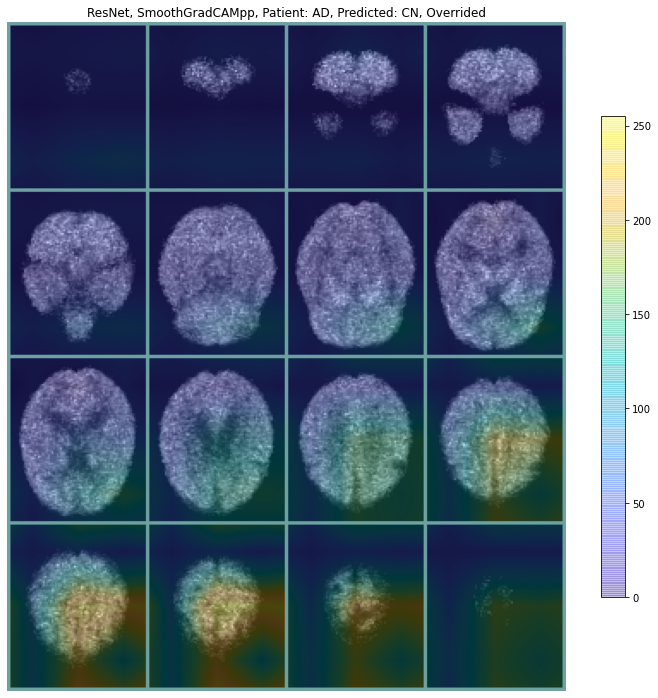

In [682]:
plot_cams = {
    'CAM':{},
    'GradCAM':{},
    'GradCAMpp':{},
    'SmoothGradCAMpp':{},
    'Saliency':{'cmap':'hot', 'alpha':1},
    'ScoreCAM':{},
    'SSCAM':{},
    'ISCAM':{},
}
images = ['CN','MCI','AD']#[:1]
observed_classes = ['CN','MCI','AD']
fig,image,mask,_ = cam_example(model,extractor_name='SmoothGradCAMpp', **{},load_image='AD',observed_class='CN', max_num_slices=16)
mask 